# Logarithms and heteroskedasticity

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1czsban/eq_is_it_correct_to_use_logarithmic/).

> Is it correct to use logarithmic transformation in order to mitigate heteroskedasticity? 
>
> For my studies I gathered data on certain preferences across a group of people. I am trying to figure out if I can pinpoint preferences to factors such as gender in this case.
>
> I used mixed ANOVA analysis with good success however one of my hypothesis came up with heteroskedasticity when doing Levene's test. [I've been] breaking my head all day on how to solve this. I've now used logarithmic transformation to all 3 test results and run another Levene's. When using the media value the test now results [in] homoskedasticity, however interaction is no longer significant?
>
> Is this the correct way to deal with this problem or is there something I am missing? Thanks in advance to everyone taking their time to help.

Although the question is about ANOVA, I'm going to reframe it in terms of regression, for two reasons:

* Discussion of heteroskedasticity is clearer in the context of regression.

* For many problems, a regression model is better than ANOVA anyway.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/log_heterosked.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## What is heteroskedasticity?

Linear regression is based on a model of the data-generating process where the independent variable `y` is the sum of

* A linear function of `x` with an unknown slope and intercept, and

* Random values drawn from a Gaussian distribution with mean 0 and unknown standard deviation, `sigma`, that does not depend on `x`.

If, contrary to the second assumption, `sigma` depends on `x`, the data-generating process is heteroskedastic.
Some amount of heteroskedasticity is common in real data, but most of the time it's not a problem, because:

*  Heteroskedasticity doesn't bias the estimated parameters of the model, only the standard errors,

* Even very strong heteroskedasticity doesn't affect the standard errors by much, and

* For practical purposes we don't need standard errors to be particularly precise.

To demonstrate, let's generate some data.
First, we'll draw `xs` from a normal distribution.

In [3]:
np.random.seed(17)

n = 200
xs = np.random.normal(30, 1, size=n)
xs.sort()

To generate heteroskedastic data, I'll use `interpolate` to construct a function where `sigma` depends on `x`.

In [4]:
from scipy.interpolate import interp1d

def interpolate(xs, sigma_seq):
    return interp1d([xs.min(), xs.max()], sigma_seq)(xs)

To generate strong heteroskedasticity, I'll vary sigma over a wide range.

In [5]:
sigmas = interpolate(xs, [0.1, 6.0])
np.mean(sigmas)

3.126391153924031

Here's what `sigma` looks like as a function of `x`.

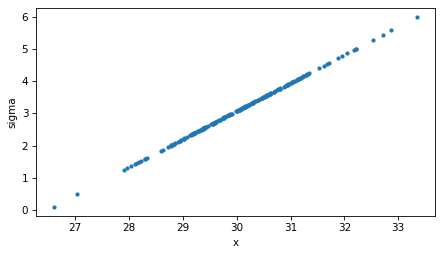

In [6]:
plt.plot(xs, sigmas, '.')

decorate(xlabel='x',
         ylabel='sigma')

Now we can generate `ys` with variable values of `sigma`.

In [7]:
ys = xs + np.random.normal(0, sigmas)

If we make a scatter plot of the data, we see a cone shape that indicates heteroskedasticity.

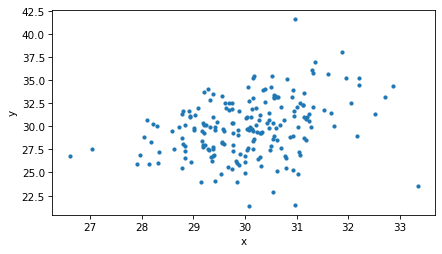

In [8]:
plt.plot(xs, ys, '.')

decorate(xlabel='x', ylabel='y')

Now let's fit a model to the data.

In [9]:
import statsmodels.api as sm

X = sm.add_constant(xs)
ols_model = sm.OLS(ys, X)
ols_results = ols_model.fit()

intercept, slope = ols_results.params
intercept, slope

(0.7580177696902339, 0.9672433174107101)

Here's what the fitted line looks like.

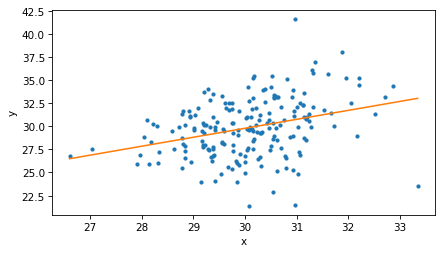

In [10]:
fys = intercept + slope * xs

plt.plot(xs, ys, '.')
plt.plot(xs, fys)

decorate(xlabel='x', ylabel='y')

If we plot the absolute values of the residuals, we can see the heteroskedasticity more clearly.

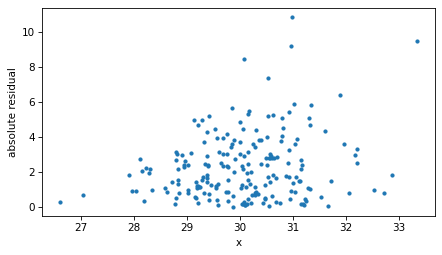

In [11]:
resid = ys - fys
plt.plot(xs, np.abs(resid), '.')

decorate(xlabel='x', ylabel='absolute residual')

## Testing for heteroskedasticity

OP mentions using the Levene test for heteroskedasticity, which is used to test whether `sigma` is different between groups.
For continuous values of `x` and `y`, we can use the Breusch-Pagan Lagrange Multiplier test:

In [12]:
from statsmodels.stats.diagnostic import het_breuschpagan

_, p_value, _, _ = het_breuschpagan(resid, ols_model.exog)
p_value

0.0006411829020109725

Or White's Lagrange Multiplier test:

In [13]:
from statsmodels.stats.diagnostic import het_white

_, p_value, _, _ = het_white(resid, ols_model.exog)
p_value

0.0019263142806157931

Both tests produce small p-values, which means that if we generate a dataset by a homoskedastic process, there is almost no chance it would have as much heteroskedasticity as the dataset we generated.

If you have never heard of either of these tests, don't panic -- neither had I under I looked them up for this example.
And don't worry about remembering them, because you should never use them again.
Like testing for normality, testing for heteroskedasticity is never useful.

Why? Because in almost any real dataset, you will find some heteroskedasticity.
So if you test for it, there are only two possible results:

* If the heteroskedasticity is small and you don't have much data, you will fail to reject the null hypothesis.

* If the heteroskedasticity is large or you have a lot of data, you will reject the null hypothesis.

Either way, you learn nothing -- and in particular, you don't learn the answer to the question you actually care about, which is whether the heteroskedasticity is so large that the effect on the standard errors is large enough that you should care.

And the answer to that question is almost always no.

## Should we care?

The dataset we generated has very large heteroskedasticity.
Let's see how much effect that has on the results.
Here are the standard errors from simple linear regression:

In [14]:
ols_results.bse

array([6.06159018, 0.20152957])

Now, there are several ways to generate standard errors that are robust in the presence of heteroskedasticity.
One is the Huber-White estimator, which we can compute like this:

In [15]:
robust_se = ols_results.get_robustcov_results(cov_type='HC3')
robust_se.bse

array([6.73913518, 0.2268012 ])

Another is to use Huber regression.

In [16]:
huber_model = sm.RLM(ys, X, M=sm.robust.norms.HuberT())
huber_results = huber_model.fit()
huber_results.bse

array([5.92709031, 0.19705786])

Another is to use quantile regression.

In [17]:
quantile_model = sm.QuantReg(ys, X)
quantile_results = quantile_model.fit(q=0.5)
quantile_results.bse

array([7.6449323 , 0.25417092])

And one more option is a wild bootstrap, which resamples the residuals by multiplying them by a random sequence of `1` and `-1`.
This way of resampling preserves heteroskedasticity, because it only changes the sign of the residuals, not the magnitude, and it maintains the relationship between those magnitudes and `x`.

In [18]:
from scipy.stats import linregress

def wild_bootstrap():
    resampled = fys + ols_results.resid * np.random.choice([1, -1], size=n)
    res = linregress(xs, resampled)
    return res.intercept, res.slope 

We can use `wild_bootstrap` to generate a sample from the sampling distributions of the intercept and slope.

In [19]:
sample = [wild_bootstrap() for i in range(1001)] 

The standard deviation of the sampling distributions is the standard error.

In [20]:
bootstrap_bse = np.std(sample, axis=0)
bootstrap_bse

array([6.63622313, 0.22341784])

Now let's put all of the result in a table.

In [21]:
columns = ['SE(intercept)', 'SE(slope)']
index = ['OLS', 'Huber-White', 'Huber', 'quantile', 'bootstrap']
data = [ols_results.bse, robust_se.bse, huber_results.bse, 
        quantile_results.bse, bootstrap_bse]
df = pd.DataFrame(data, columns=columns, index=index)
df.sort_values(by='SE(slope)')

,SE(intercept),SE(slope)
Huber,5.927090,0.197058
OLS,6.061590,0.201530
bootstrap,6.636223,0.223418
Huber-White,6.739135,0.226801
quantile,7.644932,0.254171


The standard errors we get from different methods are notably different, but the differences probably don't matter.

First, I am skeptical of the results from Huber regression.
With this kind of heteroskedasticity, the standard errors should be larger than what we get from OLS.
I'm not sure what's the problem is, and I haven't bothered to find out, because I don't think Huber regression is necessary in the first place.

The results from bootstrapping and the Huber-White estimator are the most reliable -- which suggests that the standard errors from quantile regression are too big. 

In my opinion, we don't need esoteric methods to deal with heteroskedasticity.
If it's extreme, consider using wild bootstrap.
Otherwise, just use ordinary least squares.

Now let's address OP's headline question, "Is it correct to use logarithmic transformation in order to mitigate heteroskedasticity?"

## Log transform help?

In some cases, a log transform can reduce or eliminate heteroskedasticity.
However, there are several reasons this is not a good idea in general:

* As we've seen, heteroskedasticity is not a big problem, so it usually doesn't require any mitigation.

* Taking a log transform of one or more variables in a regression model changes the meaning of the model -- it hypothesizes a relationship between the variables that might not make sense in context.

* Anyway, taking a log transform doesn't always help.

To demonstrate the last point, let's see what happens if we apply a log transform to the dependent variable:

In [22]:
log_ys = np.log10(ys)

Here's what the scatter plot looks like after the transform.

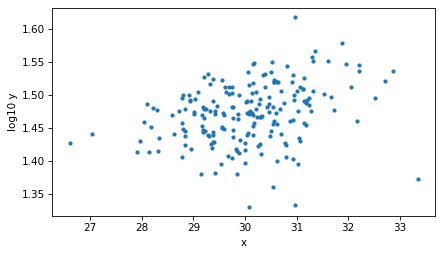

In [23]:
plt.plot(xs, log_ys, '.')

decorate(xlabel='x', ylabel='log10 y')

Here's what we get if we fit a model to the data.

In [24]:
ols_model_log = sm.OLS(log_ys, X)
ols_results_log = ols_model_log.fit()

intercept, slope = ols_results_log.params
intercept, slope

(1.072059757295944, 0.013315487289434717)

And here's the fitted line.

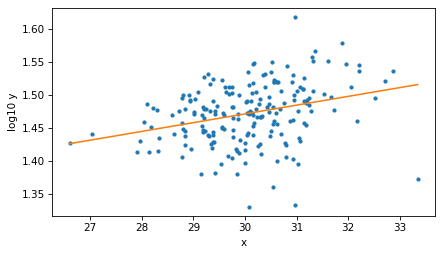

In [25]:
log_fys = intercept + slope * xs

plt.plot(xs, log_ys, '.')
plt.plot(xs, log_fys)

decorate(xlabel='x', ylabel='log10 y')

If we plot the absolute values of the residuals, we can see that the log transform did not entirely remove the heteroskedasticity.

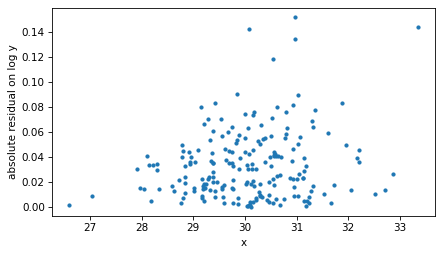

In [26]:
log_resid = log_ys - log_fys
plt.plot(xs, np.abs(log_resid), '.')

decorate(xlabel='x', ylabel='absolute residual on log y')

Which we can confirm by running the tests again (which we should never do).

In [27]:
_, p_value, _, _ = het_breuschpagan(log_resid, ols_model_log.exog)
p_value

0.002154782205265498

In [28]:
_, p_value, _, _ = het_white(log_resid, ols_model_log.exog)
p_value

0.006069762292696221

The p-values are bigger, which suggests that the log transform mitigated the heteroskedasticity a little.
But if the goal was to eliminate heteroskedasticity, the log transform didn't do it.

## Discussion

To summarize:

* Heteroskedasticity is common in real datasets -- if you test for it, you will often find it, provided you have enough data.

* Either way, testing does not answer the question you really care about, which is whether the heteroskedasticity is extreme enough to be a problem.

* Plain old linear regression is robust to heteroskedasticity, so unless it is really extreme, it is probably not a problem.

* Even in the worst case, heteroskedasticity does not bias the estimated parameters -- it only affects the standard errors -- and we don't need standard errors to be particularly precise anyway.

* Although a log transform can sometimes mitigate heteroskedasticity, it doesn't always succeed, and even if it does, it's usually not necessary.

* A log transform changes the meaning of the regression model in ways that might not make sense in context.

So, use a log transform if it makes sense in context, not to mitigate a problem that's not much of a problem in the first place.

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)